### Model A: Assume formula for r > Rc applies everywhere

In [18]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c


# Earth core radius, Earth core density
Rc = 3485 * u.km
rho_c = 13 * u.g / u.cm**3

# Earth radius, magma density
Re = 1 * u.R_earth
rho_e = 4.7 * u.g / u.cm**3

# Earth avg density
rho_avg = 5.513 * u.g / u.cm**3

# Set the parameters
kavg = (4 / 3) * np.pi * rho_avg * c.G # You can adjust the value of k
kc = (4 / 3) * np.pi * rho_c * c.G # You can adjust the value of k
ke = (4 / 3) * np.pi * rho_e * c.G # You can adjust the value of k
c = (4 / 3) * np.pi * (rho_e - rho_c) * c.G * (Rc ** 3)  # You can adjust the value of c

In [19]:
# Define the ODE as a system of first-order ODEs
def model(y, t, k, c):
    """
    y[0] = r
    y[1] = dr/dt = v
    """
    dydt = [y[1], -k * y[0] + c / y[0]**2]
    return dydt

# Set the initial conditions
r0 = 1.0 * Re  # Initial value of r
v0 = 0.0 * u.m / u.s # Initial value of dr/dt
initial_conditions = [r0.to(u.R_earth).value, v0.to(u.R_earth / u.hr).value]

Peak at t = 0.00 hours
Peak at t = 0.20 hours


/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


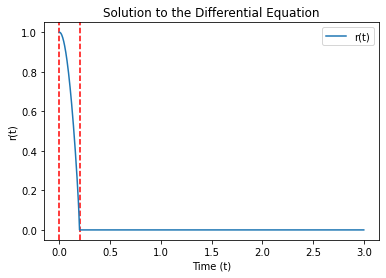

In [20]:
# Set the time grid
t = np.linspace(0, 3, 1000)  # Adjust the time range and number of points as needed

# Solve the ODE using odeint
solution = odeint(model, initial_conditions, t, args=(kc.to(u.hr ** -2).value, c.decompose().to(u.R_earth**3 / u.hr**2).value))

# Extract the solution
r_values = solution[:, 0]

# Find the indices of the peaks
peak_indices = np.where(np.diff(np.sign(np.diff(r_values))))[0] + 1
peak_indices = list(peak_indices)
peak_indices.insert(0, 0)

for i in range(len(peak_indices)):
    print('Peak at t = {:.2f} hours'.format(t[peak_indices][i]))
    plt.axvline(t[peak_indices][i], color='r', linestyle='--')

# Plot the results
plt.plot(t, r_values, label='r(t)')
plt.title('Solution to the Differential Equation')
plt.xlabel('Time (t)')
plt.ylabel('r(t)')
plt.legend()
plt.show()

In [24]:
r = np.linspace(0,  1, 1000) * u.R_earth
gR = - ke * r + c / (r ** 2)
gRorig = - kavg * r

/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [25]:
gR.decompose()

<Quantity [           -inf, -2.46757258e+06, -6.16893159e+05,
           -2.74174754e+05, -1.54223318e+05, -9.87029430e+04,
           -6.85437307e+04, -5.03586801e+04, -3.85558857e+04,
           -3.04639312e+04, -2.46758060e+04, -2.03932501e+04,
           -1.71360170e+04, -1.46011256e+04, -1.25897684e+04,
           -1.09671097e+04, -9.63908387e+03, -8.53844994e+03,
           -7.61610931e+03, -6.83553370e+03, -6.16909207e+03,
           -5.59557133e+03, -5.09846715e+03, -4.66478317e+03,
           -4.28417293e+03, -3.94831692e+03, -3.65046412e+03,
           -3.38509008e+03, -3.14763890e+03, -2.93432636e+03,
           -2.74198827e+03, -2.56796239e+03, -2.40999587e+03,
           -2.26617192e+03, -2.13485144e+03, -2.01462608e+03,
           -1.90428034e+03, -1.80276072e+03, -1.70915049e+03,
           -1.62264894e+03, -1.54255414e+03, -1.46824875e+03,
           -1.39918802e+03, -1.33488977e+03, -1.27492602e+03,
           -1.21891580e+03, -1.16651909e+03, -1.11743164e+03,
        

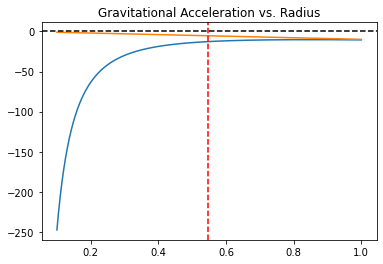

In [31]:
# Plot gravitational acceleration vs. radius

plt.plot(r[100:], gR.decompose()[100:])
plt.plot(r[100:], gRorig.decompose()[100:])
plt.axvline(Rc.to(u.R_earth).value, color='r', linestyle='--')
plt.title('Gravitational Acceleration vs. Radius')
plt.axhline(0, color='k', linestyle='--')
#plt.semilogy()

Model $r > R_c$ clearly cannot apply everywhere, since for $r < R_c$, we actually get a repulsive force. This is why the plot of $r(t)$ goes down to 0.2 and back up - which is unreasonable. We need a way to evaluate the piecewise differential equation.

### Model B: Piece-wise differential equation

$\frac{d^2r}{dt^2} =  \, \, -\frac{4}{3}\pi G \rho_c r \, \qquad \qquad \text{if } r < R_c \\ 
\qquad \quad -\frac{4}{3}\pi G \rho_c \bigg(\frac{r^3 - R_c^3}{r^2}\bigg) \quad \text{if } r \geq R_c $

We need to switch between these two equations at the core radius. Let us first plot the gravitational acceleration in this new scheme.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c


# Earth core radius, Earth core density
Rc = 3485 * u.km
rho_c = 12.5 * u.g / u.cm**3

# Earth radius, magma density
Re = 1 * u.R_earth
rho_e = 4.2 * u.g / u.cm**3

# Earth avg density
rho_avg = 5.513 * u.g / u.cm**3

# Set the parameters
kavg = (4 / 3) * np.pi * rho_avg * c.G # You can adjust the value of k
kc = (4 / 3) * np.pi * rho_c * c.G # You can adjust the value of k
ke = (4 / 3) * np.pi * rho_e * c.G # You can adjust the value of k
c = (4 / 3) * np.pi * (rho_e - rho_c) * c.G * (Rc ** 3)  # You can adjust the value of c

In [2]:
r = np.linspace(0,  1, 1000) * u.R_earth
g_out = - ke * r + c / (r ** 2)
g_in = - kc * r
gRorig = - kavg * r

/Users/shri/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


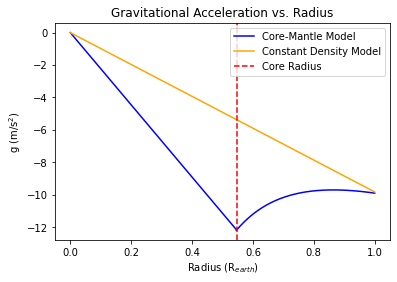

In [27]:
# Plot gravitational acceleration vs. radius

core_idx = np.where(r.to(u.R_earth).value < Rc.to(u.R_earth).value)[0][-1]

plt.plot(r[core_idx:], g_out.decompose()[core_idx:], color = 'blue', label = 'Core-Mantle Model')
plt.plot(r[:core_idx], g_in.decompose()[:core_idx], color = 'blue')
plt.plot(r, gRorig.decompose(), color = 'orange', label = 'Constant Density Model')
plt.axvline(Rc.to(u.R_earth).value, color='r', linestyle='--', label = 'Core Radius')
plt.title('Gravitational Acceleration vs. Radius')
plt.xlabel('Radius (R$_{earth}$)')
plt.ylabel('g (m/s$^2$)')
plt.legend()
plt.savefig("g_varydensity.png", bbox_inches='tight', dpi=300)

In [36]:
# Define the acceleration due to gravity as functions
g_out_func = lambda r, k, c: - k * r + c / (r ** 2)
g_in_func = lambda r, k: - k * r

# Define the ODE as a system of first-order ODEs
def model_final(y, t, ke, kc, c):
    """
    y[0] = r
    y[1] = dr/dt = v
    """
    if y[0] < Rc.to(u.R_earth).value:
        dydt = [y[1], g_in_func(y[0], kc)]
    else:
        dydt = [y[1], g_out_func(y[0], ke, c)]
    return dydt

def model_old(y, t, k):
    """
    y[0] = r
    y[1] = dr/dt = v
    """
    dydt = [y[1], -k * y[0]]
    return dydt


In [37]:
# Set the initial conditions
r0 = 1.0 * Re  # Initial value of r
v0 = 0.0 * u.m / u.s # Initial value of dr/dt
initial_conditions = [r0.to(u.R_earth).value, v0.to(u.R_earth / u.hr).value]

Peak at t = 0.00 hours
Peak at t = 0.55 hours
Peak at t = 1.10 hours
Peak at t = 1.65 hours
Peak at t = 2.20 hours
Peak at t = 2.75 hours


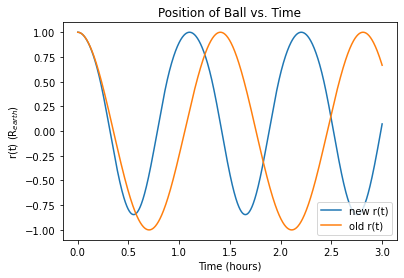

In [43]:
# Set the time grid
t = np.linspace(0, 3, 1000) # Adjust the time range and number of points as needed

# Solve the ODE using odeint
solution = odeint(model_final, initial_conditions, t, args=(ke.to(u.hr ** -2).value, kc.to(u.hr ** -2).value, c.decompose().to(u.R_earth**3 / u.hr**2).value))
solution_old = odeint(model_old, initial_conditions, t, args=(kavg.to(u.hr ** -2).value,))

# Extract the solution
r_values = solution[:, 0]
r_values_old = solution_old[:, 0]

# Find the indices of the peaks
peak_indices = np.where(np.diff(np.sign(np.diff(r_values))))[0] + 1
peak_indices = list(peak_indices)
peak_indices.insert(0, 0)

for i in range(len(peak_indices)):
    print('Peak at t = {:.2f} hours'.format(t[peak_indices][i]))
    #plt.axvline(t[peak_indices][i], color='r', linestyle='--')

# Plot the results
plt.plot(t, r_values, label='new r(t)')
plt.plot(t, r_values_old, label='old r(t)')
plt.title('Position of Ball vs. Time')
plt.xlabel('Time (hours)')
plt.ylabel('r(t) (R$_{earth}$)')
plt.legend(loc = 'lower right')
plt.savefig("ballposn.png", bbox_inches='tight', dpi=300)

In [31]:
((1.10) * u.hr).to(u.min)

<Quantity 66. min>